In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, MaxPooling2D, Conv2D, Flatten
from keras.optimizers import Adam
from keras import regularizers
from keras import optimizers
from keras import initializers
from keras.preprocessing import image

import keras.backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.patches as patches

Using TensorFlow backend.


In [3]:
# Read images
images = np.zeros((1334,260,400))

for i in range(480):
    filename = 'dataOpenedEye/openedEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    images[i] = img

for i in range(81):
    filename = 'dataPavel/pavelEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    images[i+480] = img
    
for i in range(74):
    filename = 'dataYannick/yannickEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    images[i+561] = img

for i in range(75):
    filename = 'dataKevin/kevinEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    images[i+635] = img 

for i in range(216):
    filename = 'dataAli/aliEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    images[i+710] = img
    
for i in range(209):
    filename = 'dataMarie/marieEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    images[i+926] = img
    
for i in range(199):
    filename = 'dataHelene/heleneEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    images[i+1135] = img
       
    
images = np.reshape(images, (images.shape[0], images.shape[1], images.shape[2], 1))

# Rescale images
images = images/255.

images.shape

(1334, 260, 400, 1)

In [4]:
# Read target values
target1 = pd.read_csv('dataOpenedEye/dataPupilCenter.csv')
target2 = pd.read_csv('dataPavel/pavelPupilCenter.csv')
target3 = pd.read_csv('dataYannick/yannickPupilCenter.csv')
target4 = pd.read_csv('dataKevin/kevinPupilCenter.csv')
target5 = pd.read_csv('dataAli/aliPupilCenter.csv')
target6 = pd.read_csv('dataMarie/mariePupilCenter.csv')
target7 = pd.read_csv('dataHelene/helenePupilCenter.csv')
target = [target1, target2, target3, target4, target5, target6, target7]
target = pd.concat(target)

target.shape

(1334, 3)

In [5]:
# Remove missing values
images = images[target.xcentral != '?']
target = target[target.xcentral != '?']
target = target.astype('float32')
target.shape

(1280, 3)

In [6]:
# Put target data in shape
targetX = target['xcentral'].values.reshape((target['xcentral'].shape[0], 1))
targetY = target['ycentral'].values.reshape((target['ycentral'].shape[0], 1))

# Rescale targets between 0 and 1 
targetX = targetX/400.
targetY = targetY/260.

targetTrain = np.concatenate((targetX, targetY), axis=1)
targetTrain.shape

(1280, 2)

In [7]:
# Data augmentation by adding horizontal mirror images
imagesFlipped = np.flip(images, axis=2)

targetFlipped = np.zeros(targetTrain.shape)
targetFlipped[:,0] = 1-targetTrain[:,0]
targetFlipped[:,1] = targetTrain[:,1]

images = np.concatenate((images, imagesFlipped), axis=0)
targetTrain = np.concatenate((targetTrain, targetFlipped), axis=0)

In [ ]:
%matplotlib notebook
# Image to display
index=1090

display = np.reshape(images[index], (260,400))
box = targetTrain[index]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(display, cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((box[0]*400-60,box[1]*260-60),120,120,linewidth=1,edgecolor='y',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [8]:
# Shuffle data
xtrain, ytrain = shuffle(images, targetTrain, random_state=0)
#xvalid = xtrain[512:]
#xtrain = xtrain[:512]
#yvalid = ytrain[512:]
#ytrain = ytrain[:512]

In [9]:
def model(Xshape):
    
    mod = Sequential()
    mod.add(Conv2D(4, (7, 7), activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.0), input_shape=Xshape))
    mod.add(MaxPooling2D(pool_size=(4, 4)))
    
    mod.add(Conv2D(8, (7, 7), activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.0)))
    mod.add(MaxPooling2D(pool_size=(4, 4)))

    mod.add(Flatten())
#    mod.add(Dense(256, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
    mod.add(Dense(128, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.02)))
#    mod.add(Dense(256, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.0)))
    mod.add(Dense(2, activation='sigmoid', kernel_initializer='glorot_normal'))
    
    return mod

In [10]:
mymodel = model(xtrain.shape[1:])
opt = optimizers.Adam(lr=0.0001)
mymodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [11]:
# First train with small mini batch size and default learning rate
mymodel.fit(xtrain, ytrain, epochs = 30, batch_size=64)

Epoch 1/40
2560/2560 [==============================] - 102s 40ms/step - loss: 1.2292 - acc: 0.5824
Epoch 2/40
2560/2560 [==============================] - 101s 39ms/step - loss: 0.0497 - acc: 0.7398
Epoch 3/40
2560/2560 [==============================] - 100s 39ms/step - loss: 0.0202 - acc: 0.8238
Epoch 4/40
2560/2560 [==============================] - 100s 39ms/step - loss: 0.0195 - acc: 0.8250
Epoch 5/40
2560/2560 [==============================] - 100s 39ms/step - loss: 0.0182 - acc: 0.8273
Epoch 6/40
2560/2560 [==============================] - 100s 39ms/step - loss: 0.0177 - acc: 0.8262
Epoch 7/40
2560/2560 [==============================] - 101s 39ms/step - loss: 0.0194 - acc: 0.8273
Epoch 8/40
2560/2560 [==============================] - 102s 40ms/step - loss: 0.0155 - acc: 0.8523
Epoch 9/40
2560/2560 [==============================] - 103s 40ms/step - loss: 0.0170 - acc: 0.8328
Epoch 10/40
2560/2560 [==============================] - 102s 40ms/step - loss: 0.0143 - acc: 0.8531

KeyboardInterrupt: 

In [12]:
# Then train with smaller learning rate and larger batch size
K.set_value(mymodel.optimizer.lr, 0.0005)
mymodel.fit(xtrain, ytrain, epochs = 5, batch_size=128)
K.set_value(mymodel.optimizer.lr, 0.0001)
mymodel.fit(xtrain, ytrain, epochs = 5, batch_size=256)

Epoch 1/10
2560/2560 [==============================] - 102s 40ms/step - loss: 0.0093 - acc: 0.9145
Epoch 2/10
2560/2560 [==============================] - 101s 40ms/step - loss: 0.0071 - acc: 0.9324
Epoch 3/10
2560/2560 [==============================] - 102s 40ms/step - loss: 0.0064 - acc: 0.9316
Epoch 4/10
2560/2560 [==============================] - 102s 40ms/step - loss: 0.0058 - acc: 0.9332
Epoch 5/10
2560/2560 [==============================] - 106s 41ms/step - loss: 0.0058 - acc: 0.9309
Epoch 6/10
2560/2560 [==============================] - 103s 40ms/step - loss: 0.0062 - acc: 0.9277
Epoch 7/10
2560/2560 [==============================] - 126s 49ms/step - loss: 0.0064 - acc: 0.9293
Epoch 8/10
2560/2560 [==============================] - 157s 61ms/step - loss: 0.0058 - acc: 0.9320
Epoch 9/10
2560/2560 [==============================] - 159s 62ms/step - loss: 0.0056 - acc: 0.9320
Epoch 10/10
2560/2560 [==============================] - 153s 60ms/step - loss: 0.0060 - acc: 0.9273

KeyboardInterrupt: 

In [13]:
# Make the prediction on all
ypredict = mymodel.predict(images)

X mean and stdev of diff:  -0.0036744746976182796 0.05575799076233427
Y mean and stdev of diff:  0.00019380895028007217 0.05575799076233427


<IPython.core.display.Javascript object>


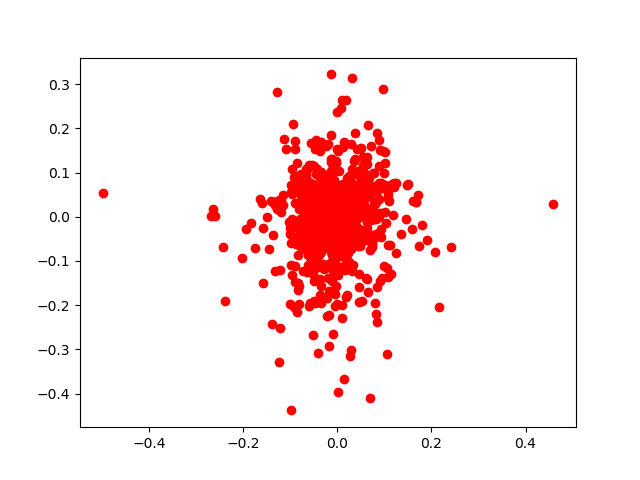

In [45]:
# Plot the diff between prediction and target values
diff = ypredict-targetTrain

print('X mean and stdev of diff: ', np.mean(diff[:,0]), np.std(diff[:,1]))
print('Y mean and stdev of diff: ', np.mean(diff[:,1]), np.std(diff[:,1]))

%matplotlib notebook
plt.plot(diff[:,0], diff[:,1],'ro')
plt.show()

<IPython.core.display.Javascript object>


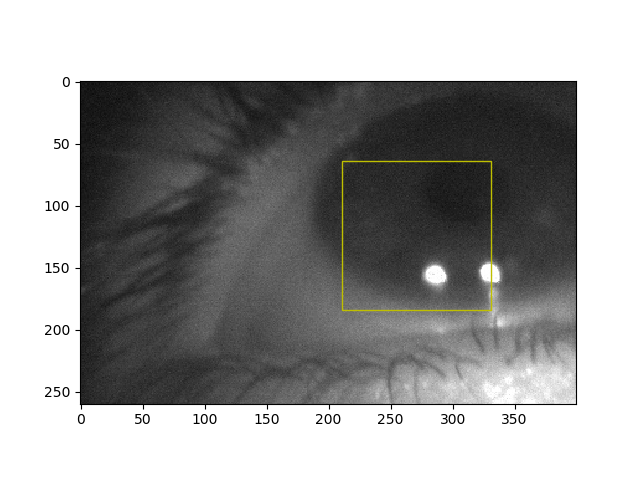

In [49]:
#%matplotlib notebook
index=3

display = np.reshape(images[index], (260,400))
box = ypredict[index]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(display, cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((box[0]*400-60,box[1]*260-60),120,120,linewidth=1,edgecolor='y',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [ ]:
# Make the prediction for valid dataset
validPredict = mymodel.predict(xvalid)

In [ ]:
index=14

display = np.reshape(xvalid[index], (260,400))
box = validPredict[index]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(display, cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((box[0]*400-60,box[1]*260-60),120,120,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [21]:
# Make the prediction on a totally new dataset
# Read images
newImages = np.zeros((209,260,400))

for i in range(209):
    filename = 'dataJade/jadeEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    newImages[i] = img

        
newImages = np.reshape(newImages, (newImages.shape[0], newImages.shape[1], newImages.shape[2], 1))

# Rescale images
newImages = newImages/255.

# Make the prediction for valid dataset
newImagesPredict = mymodel.predict(newImages)

<IPython.core.display.Javascript object>


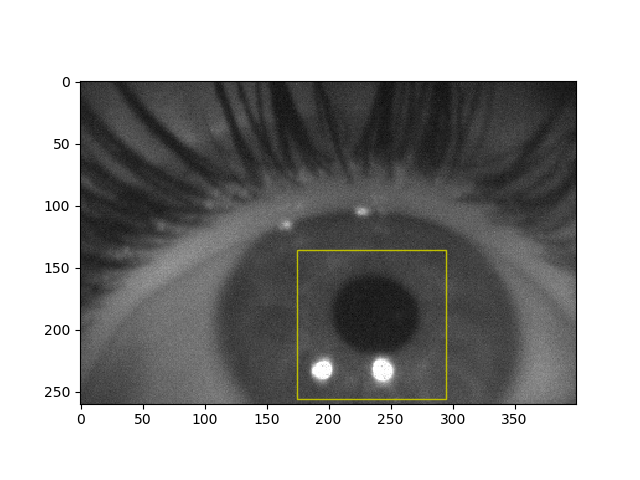

In [53]:
# Image to display
index=20

display = np.reshape(newImages[index], (260,400))
box = newImagesPredict[index]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(display, cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((box[0]*400-60,box[1]*260-60),120,120,linewidth=1,edgecolor='y',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()
